# Exploration of knowledge graph completion datasets

To use this notebook, choose a dataset in the cell below and run the cells

This notebook includes:
- Calculation of number of entities and relations in train, dev, test datasets
- Screening for full triple duplication
- Screening for entity-swap type train-dev-test split overlaps (i.e. same relation, subject and object swapped around)
- Calculation of frequencies of entities and relations in train, dev, test datasets, and boxplots of frequency distributions
- Visualisations of the knowledge graph using the networkx library

In [2]:
# choose a dataset

DATASET = "nations" # "umls", "nations", "kinship", "fb122", "fb15k-237", "wn18rr", "yago3-10"

### Setup

In [3]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import splitext
from typing import Optional, List, Tuple, Dict
import networkx as nx

In [4]:
# load dataset

def read_triples(path: str) -> List[Tuple[str, str, str]]:
    triples = []

    tmp = splitext(path)
    ext = tmp[1] if len(tmp) > 1 else None

    with open(path, 'rt') as f:
        for line in f.readlines():
            if ext is not None and ext.lower() == '.tsv':
                s, p, o = line.split('\t')
            else:
                s, p, o = line.split()
            triples += [(s.strip(), p.strip(), o.strip())]
    return triples

triples_train = read_triples(f"./data/{DATASET}/train.tsv")
triples_dev = read_triples(f"./data/{DATASET}/dev.tsv")
triples_test = read_triples(f"./data/{DATASET}/test.tsv")
triples_all = triples_train + triples_dev + triples_test

df_train = pd.read_csv(f"./data/{DATASET}/train.tsv", sep='\t', header=None, names=["subject", "predicate", "object"])
df_dev = pd.read_csv(f"./data/{DATASET}/dev.tsv", sep='\t', header=None, names=["subject", "predicate", "object"])
df_test = pd.read_csv(f"./data/{DATASET}/test.tsv", sep='\t', header=None, names=["subject", "predicate", "object"])
df_all = pd.concat([df_train, df_dev, df_test])

### KG stats

In [5]:
# make set set of entities and predicates, and count number of each

def get_kg_stats_dict(triples, split_str):
    subject_set = {s for (s, _, _) in triples}
    object_set = {o for (_, _, o) in triples}
    entity_set = subject_set | object_set
    relation_set = {p for (_, p, _) in triples}
    
    stats = {"Split": split_str,
            "Entities count": len(entity_set),
            "Subjects count": len(subject_set),
            "Objects count": len(object_set),
            "Relations count": len(relation_set),
            "Triples count": len(triples)
            }
    
    return stats

def get_kg_stats_df(triples_all, triples_train, triples_dev, triples_test):
    
    stats_all = get_kg_stats_dict(triples_all, "all")
    stats_train = get_kg_stats_dict(triples_train, "train")
    stats_dev = get_kg_stats_dict(triples_dev, "dev")
    stats_test = get_kg_stats_dict(triples_test, "test")
    
    df_stats = pd.DataFrame()
    for stats_dict in [stats_all, stats_train, stats_dev, stats_test]:
        df_stats = df_stats.append(stats_dict, ignore_index=True)
    
    return df_stats
    
df_stats = get_kg_stats_df(triples_all, triples_train, triples_dev, triples_test)

In [5]:
df_stats

,Entities count,Objects count,Relations count,Split,Subjects count,Triples count
0,14.0,14.0,55.0,all,14.0,1992.0
1,14.0,14.0,55.0,train,14.0,1592.0
2,14.0,14.0,45.0,dev,14.0,199.0
3,14.0,14.0,41.0,test,14.0,201.0


### Triple duplication / train-dev-test overlap via entity-swapping

In [6]:
# Check for fully duplicated triples

print(f"Number of duplicated triples: {len(triples_all)-len(set(triples_all))}")

Number of duplicated triples: 0


In [7]:
print("Data split overlaps via entity-swapping of triples, i.e. triples with same relation but entities swapped\n")

# train-dev overlap via entity swapping (number of train triples for which the entity-swapped version exists in dev set)
entity_swapped_dev = [(o, p, s) for (s, p, o) in triples_dev]
print(f"train-dev: {len(set(triples_train) & set(entity_swapped_dev))}/{len(triples_train)}")

# train-test overlap via entity swapping  (number of train triples for which the entity-swapped version exists in test set)
entity_swapped_test = [(o, p, s) for (s, p, o) in triples_test]
print(f"train-test: {len(set(triples_train) & set(entity_swapped_test))}/{len(triples_train)}")

# dev-test overlap via entity swapping (number of dev triples for which the entity-swapped version exists in test set)
print(f"dev_test: {len(set(triples_dev) & set(entity_swapped_test))}/{len(triples_dev)}")

Data split overlaps via entity-swapping of triples, i.e. triples with same relation but entities swapped

train-dev: 114/1592
train-test: 106/1592
dev_test: 21/199


### Entity and relation frequencies

In [6]:
# count frequencies of each entity and predicate, make df of number of each

def get_entity_relation_frequencies(triples):
    subject_set = {s for (s, _, _) in triples}
    object_set = {o for (_, _, o) in triples}
    entity_set = subject_set | object_set
    relation_set = {p for (_, p, _) in triples}
    
    entity_counts = {}        
    for entity in entity_set:
        entity_counts[entity] = 0
        for triple in triples:
            if entity == triple[0] or entity == triple[2]:
                entity_counts[entity] += 1
    
    relation_counts = {}        
    for relation in relation_set:
        relation_counts[relation] = 0
        for triple in triples:
            if relation == triple[1]:
                relation_counts[relation] += 1
    
    return entity_counts, relation_counts

entity_counts_train, relation_counts_train = get_entity_relation_frequencies(triples_train)
entity_counts_dev, relation_counts_dev = get_entity_relation_frequencies(triples_dev)
entity_counts_test, relation_counts_test = get_entity_relation_frequencies(triples_test)

In [7]:
df_entity_counts = pd.DataFrame.from_dict({"entity_counts": entity_counts_train}).sort_values("entity_counts")
display(df_entity_counts)
df_entity_counts_dev = pd.DataFrame.from_dict({"entity_counts": entity_counts_dev}).sort_values("entity_counts")
display(df_entity_counts_dev)
df_entity_counts_test = pd.DataFrame.from_dict({"entity_counts": entity_counts_test}).sort_values("entity_counts")
display(df_entity_counts_test)

,entity_counts
burma,105
jordan,123
indonesia,162
cuba,176
china,189
israel,191
brazil,205
egypt,223
poland,234
india,250


,entity_counts
jordan,9
burma,18
indonesia,21
india,25
netherlands,26
cuba,28
egypt,28
israel,29
china,30
brazil,31


,entity_counts
jordan,14
poland,20
burma,23
israel,23
brazil,24
india,27
netherlands,27
cuba,28
china,30
ussr,30


In [8]:
df_entity_counts = pd.DataFrame.from_dict({"entity_counts": entity_counts_train}).sort_index()
display(df_entity_counts)
df_entity_counts_dev = pd.DataFrame.from_dict({"entity_counts": entity_counts_dev}).sort_index()
display(df_entity_counts_dev)
df_entity_counts_test = pd.DataFrame.from_dict({"entity_counts": entity_counts_test}).sort_index()
display(df_entity_counts_test)

,entity_counts
brazil,205
burma,105
china,189
cuba,176
egypt,223
india,250
indonesia,162
israel,191
jordan,123
netherlands,260


,entity_counts
brazil,31
burma,18
china,30
cuba,28
egypt,28
india,25
indonesia,21
israel,29
jordan,9
netherlands,26


,entity_counts
brazil,24
burma,23
china,30
cuba,28
egypt,33
india,27
indonesia,32
israel,23
jordan,14
netherlands,27


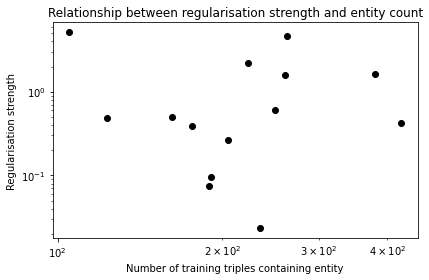

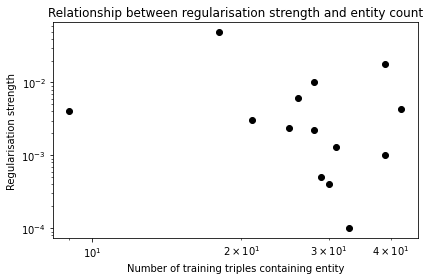

In [48]:
# entity frequency against learnt regularisation parameter value

lst = list(np.array([[0.0013],
[0.0490],
[0.0004],
[0.0022],
[0.0100],
[0.0024],
[0.0031],
[0.0005],
[0.0040],
[0.0061],
[0.0001],
[0.0043],
[0.0010],
[0.0179]])[:,-1])

df_entity_counts["reg_val"] = lst
df_entity_counts["reg_val_times_n"] = df_entity_counts["reg_val"]*df_entity_counts["entity_counts"]

plot = df_entity_counts.plot("entity_counts", "reg_val_times_n", style="o", legend=None, markerfacecolor="k", markeredgecolor="k")
plt.xlabel("Number of training triples containing entity")
plt.ylabel("Regularisation strength")
plt.title("Relationship between regularisation strength and entity count")
plot.set_yscale('log')
plot.set_xscale('log')
plt.tight_layout()
plt.savefig("realmeta_nations/plots/entity_regstrength_freq_training.png", dpi=250)
plt.show()

df_entity_counts_dev["reg_val"] = lst
plot = df_entity_counts_dev.plot("entity_counts", "reg_val", style="o", legend=None, markerfacecolor="k", markeredgecolor="k")
plt.xlabel("Number of training triples containing entity")
plt.ylabel("Regularisation strength")
plt.title("Relationship between regularisation strength and entity count")
plot.set_yscale('log')
plot.set_xscale('log')
plt.tight_layout()
plt.show()

In [27]:
df_relation_counts = pd.DataFrame.from_dict({"relation_counts": relation_counts_train}).sort_values("relation_counts")
display(df_relation_counts)
df_relation_counts_dev = pd.DataFrame.from_dict({"relation_counts": relation_counts_dev}).sort_values("relation_counts")
display(df_relation_counts_dev)
df_relation_counts_test = pd.DataFrame.from_dict({"relation_counts": relation_counts_test}).sort_values("relation_counts")
display(df_relation_counts_test)

,relation_counts
attackembassy,1
aidenemy,2
severdiplomatic,2
lostterritory,2
warning,3
expeldiplomats,4
unoffialacts,4
relemigrants,5
dependent,5
militaryactions,6


,relation_counts
accusation,1
pprotests,1
nonviolentbehavior,1
warning,1
relstudents,1
timesincewar,1
emigrants3,1
eemigrants,1
releconomicaid,1
duration,1


,relation_counts
violentactions,1
militaryactions,1
lostterritory,1
pprotests,1
relbooktranslations,1
relexportbooks,1
dependent,1
duration,1
nonviolentbehavior,1
expeldiplomats,1


In [28]:
df_relation_counts = pd.DataFrame.from_dict({"relation_counts": relation_counts_train}).sort_index()
display(df_relation_counts)
df_relation_counts_dev = pd.DataFrame.from_dict({"relation_counts": relation_counts_dev}).sort_index()
display(df_relation_counts_dev)
df_relation_counts_test = pd.DataFrame.from_dict({"relation_counts": relation_counts_test}).sort_index()
display(df_relation_counts_test)

,relation_counts
accusation,19
aidenemy,2
attackembassy,1
blockpositionindex,47
booktranslations,26
boycottembargo,8
commonbloc0,27
commonbloc1,80
commonbloc2,45
conferences,58


,relation_counts
accusation,1
blockpositionindex,5
commonbloc0,2
commonbloc1,7
commonbloc2,4
conferences,6
dependent,1
duration,1
economicaid,2
eemigrants,1


,relation_counts
accusation,3
blockpositionindex,4
booktranslations,2
commonbloc0,2
commonbloc1,10
commonbloc2,5
conferences,2
dependent,1
duration,1
embassy,18


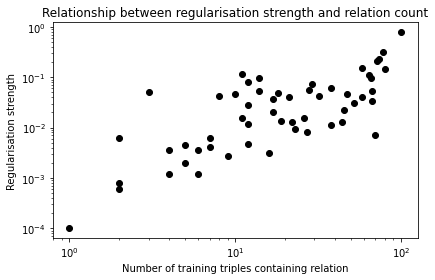

In [47]:
# predicate frequency against learnt regularisation parameter value

lst = list(np.array([[0.0007],
        [0.0031],
        [0.0001],
        [0.0010],
        [0.0006],
        [0.0053],
        [0.0003],
        [0.0018],
        [0.0005],
        [0.0026],
        [0.0009],
        [0.0009],
        [0.0047],
        [0.0003],
        [0.0079],
        [0.0006],
        [0.0009],
        [0.0010],
        [0.0020],
        [0.0017],
        [0.0008],
        [0.0030],
        [0.0003],
        [0.0006],
        [0.0002],
        [0.0026],
        [0.0069],
        [0.0007],
        [0.0005],
        [0.0039],
        [0.0004],
        [0.0022],
        [0.0006],
        [0.0015],
        [0.0014],
        [0.0004],
        [0.0024],
        [0.0013],
        [0.0031],
        [0.0041],
        [0.0106],
        [0.0012],
        [0.0003],
        [0.0004],
        [0.0004],
        [0.0001],
        [0.0027],
        [0.0019],
        [0.0067],
        [0.0003],
        [0.0003],
        [0.0016],
        [0.0002],
        [0.0167],
        [0.0006]])[:,-1])

df_relation_counts["reg_val"] = lst
df_relation_counts["reg_val_times_n"] = df_relation_counts["reg_val"]*df_relation_counts["relation_counts"]

plot = df_relation_counts.plot("relation_counts", "reg_val_times_n", style="o", legend=None, markerfacecolor="k", markeredgecolor="k")
plt.xlabel("Number of training triples containing relation")
plt.ylabel("Regularisation strength")
plt.title("Relationship between regularisation strength and relation count")
plot.set_yscale('log')
plot.set_xscale('log')
plt.tight_layout()
plt.savefig("realmeta_nations/plots/relation_regstrength_freq_training.png", dpi=250)

# plot = sns.regplot(df_relation_counts['relation_counts'],df_relation_counts['reg_val_times_n'])
# plot.set_yscale('log')
# plot.set_xscale('log')

plt.show()

# df_relation_counts_dev["reg_val"] = lst
# df_relation_counts_dev.plot("relation_counts", "reg_val", style="o")
# plt.show()

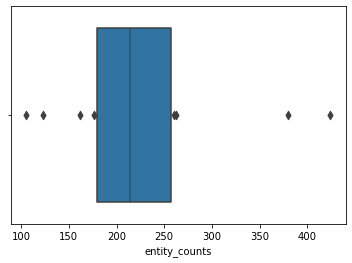

In [30]:
sns.boxenplot(x=df_entity_counts["entity_counts"])
plt.show()

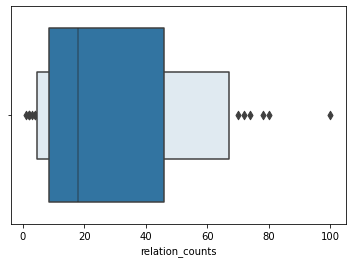

In [31]:
sns.boxenplot(x=df_relation_counts["relation_counts"])
plt.show()

### KG visualisation

Visualisation of a specific relation

In [20]:
# Specify relation to visualise

RELATION = "reltreaties"

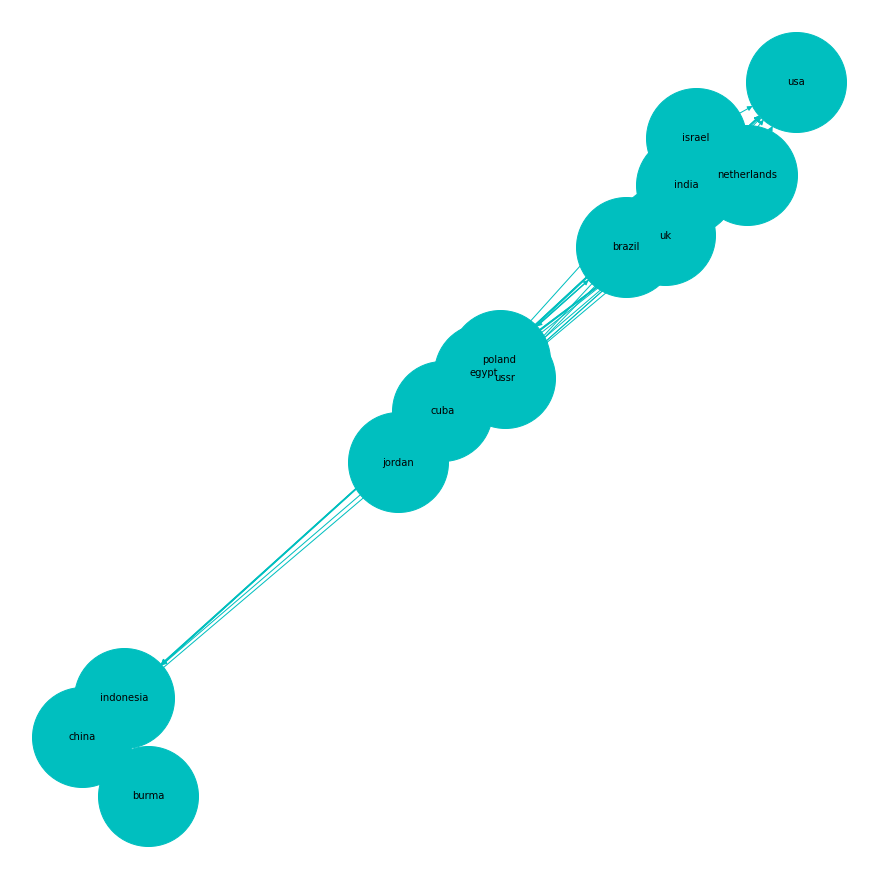

In [21]:
kg=nx.from_pandas_edgelist(df_all[df_all["predicate"]==RELATION], "subject", "object", 
                          edge_attr=None, create_using=nx.MultiDiGraph(), )

plt.figure(figsize=(12,12))

pos = nx.spring_layout(kg)
nx.draw(kg, with_labels=True, node_color='c', edge_color="c", font_size=10, node_size=10000, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Reference: https://www.kaggle.com/arifali77/knowledge-graph

Visualisation of entire knowledge graph

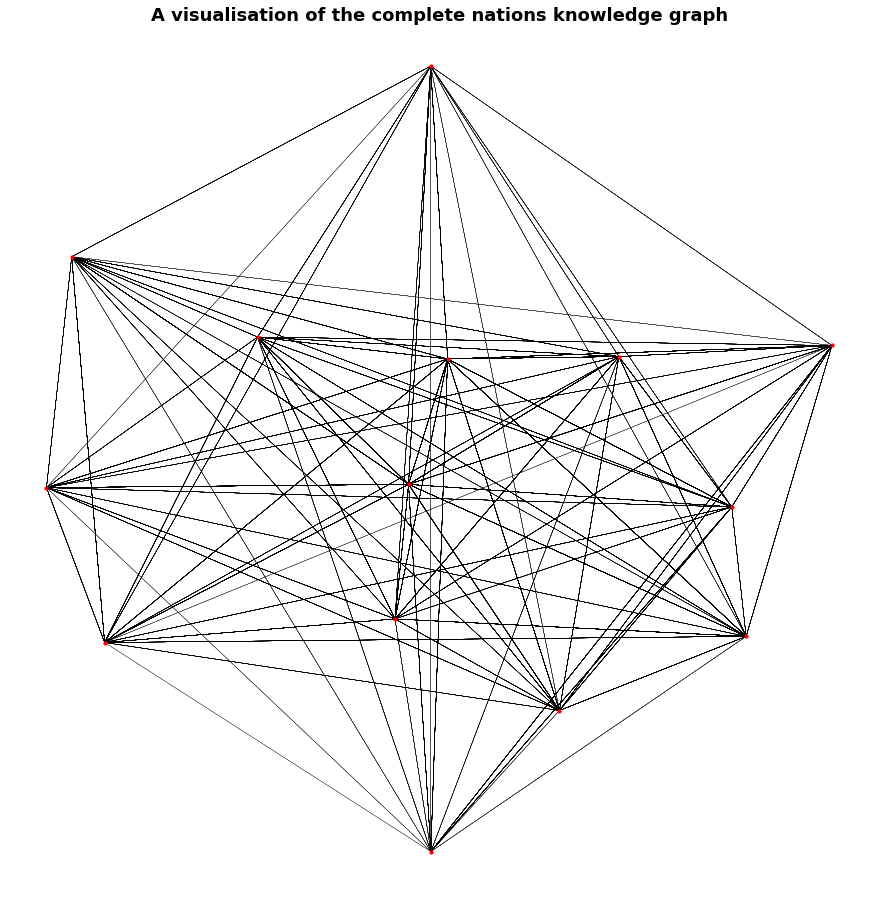

In [22]:
kg=nx.from_pandas_edgelist(df_all, "subject", "object", 
                          edge_attr=None, create_using=nx.MultiGraph(), )

plt.figure(figsize=(12,12))

pos = nx.spring_layout(kg)
nx.draw(kg, with_labels=False, node_color='r', edge_color="black", width=0.2, node_size=10, edge_cmap=plt.cm.Blues, pos = pos)
plt.title(f"A visualisation of the complete {DATASET} knowledge graph", size=18, fontweight='bold')
plt.show()